# Introduction

Welcome to the exciting realm where art meets technology! In this captivating competition, we dive into the fusion of data science and artistic expression, exploring the realm of Generative Adversarial Networks (GANs) to emulate the timeless style of renowned artists like Claude Monet. Artistic works are often distinguished by the unique strokes, color choices, and that elusive "je ne sais quoi." Thanks to the incredible capabilities of GANs, we now have the power to recreate and imitate these artistic styles algorithmically. Your mission? To bring Monet's distinctive style to life in your own photos or even craft entirely new creations. Computer vision, especially with the prowess of GANs, has made remarkable strides in mimicking objects convincingly. However, the challenge posed here goes beyond mere object replication; it delves into the intricate world where data science and art converge. Can GANs, through the lens of (data) science, fool classifiers into believing that your creations are authentic Monets? That's the intriguing puzzle you're about to unravel!

The GAN you'll be constructing comprises two essential components: the generator, responsible for crafting the images in Monet's style, and the discriminator, tasked with distinguishing between real and generated images. As these two models engage in a dynamic dance, the generator strives to outsmart the discriminator, and the discriminator aims to accurately classify the origin of each image. Your ultimate quest is to craft a GAN capable of generating an impressive collection of 7,000 to 10,000 Monet-style images. So, buckle up and prepare to embark on a journey where algorithms and creativity converge to push the boundaries of what's possible in the world of digital artistry. Let the competition begin!

# Filteration

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [2]:
AUTO = tf.data.experimental.AUTOTUNE

import re
import os
import math
import random
import cv2

In [3]:
# import matplotlib.image as mpimg 
# import matplotlib.pyplot as plt 

# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [4]:
!ls /kaggle/input

gan-getting-started


In [5]:
#GCS_PATH_MONET = KaggleDatasets().get_gcs_path('monet-tfrecords-extdata')
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
#GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
#GCS_PATH_MONET,
GCS_PATH

'gs://kds-a093332d48cedf60f953f90a6c80dac462a02fedf91926987de1a0fe'

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [7]:
BATCH_SIZE =  4
EPOCHS_NUM = 30

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')
print(f"Batch_size: {BATCH_SIZE}")
print(f"Epochs number: {EPOCHS_NUM}")

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038
Batch_size: 4
Epochs number: 30


In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [10]:
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286]) #resizing to 286 x 286 x 3
        image = tf.image.random_crop(image, size=[256, 256, 3]) # randomly cropping to 256 x 256 x 3
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
        ## random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds, monet_ds, photo_ds

Let's load in our datasets.

In [11]:
full_dataset, monet_ds, photo_ds = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

# visualization input

In [12]:
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

In [13]:
BASE_PATH = '../input/gan-getting-started/'
MONET_PATH = os.path.join(BASE_PATH, 'monet_jpg')
PHOTO_PATH = os.path.join(BASE_PATH, 'photo_jpg')

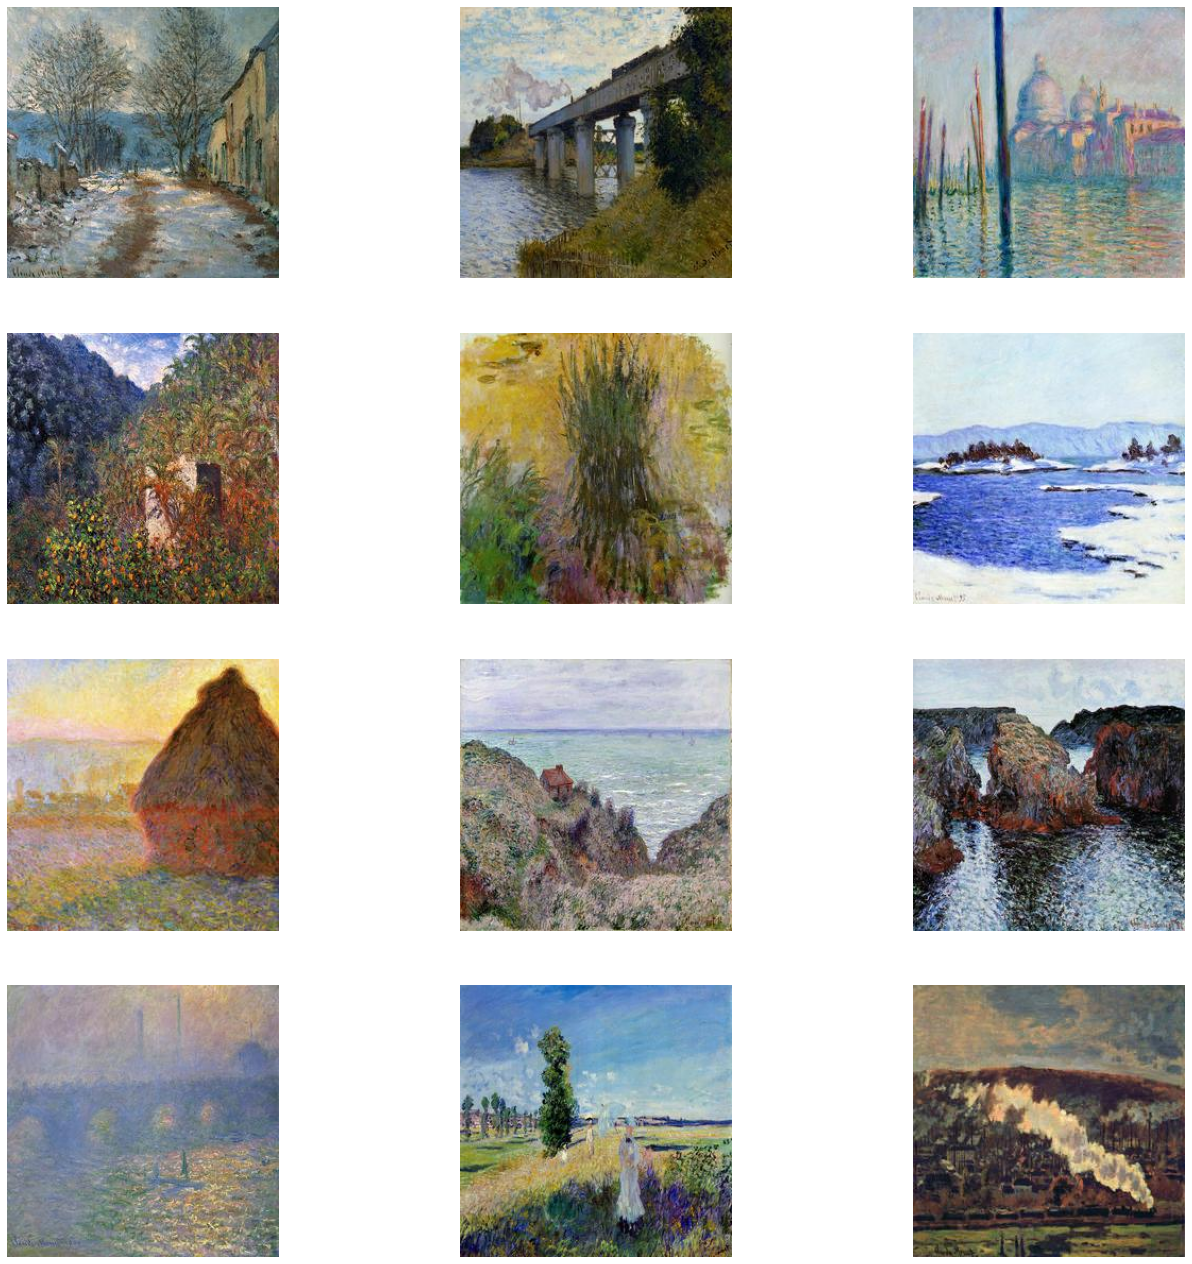

In [14]:
batch_visualization(MONET_PATH, 12, is_random=True, figsize=(23, 23))

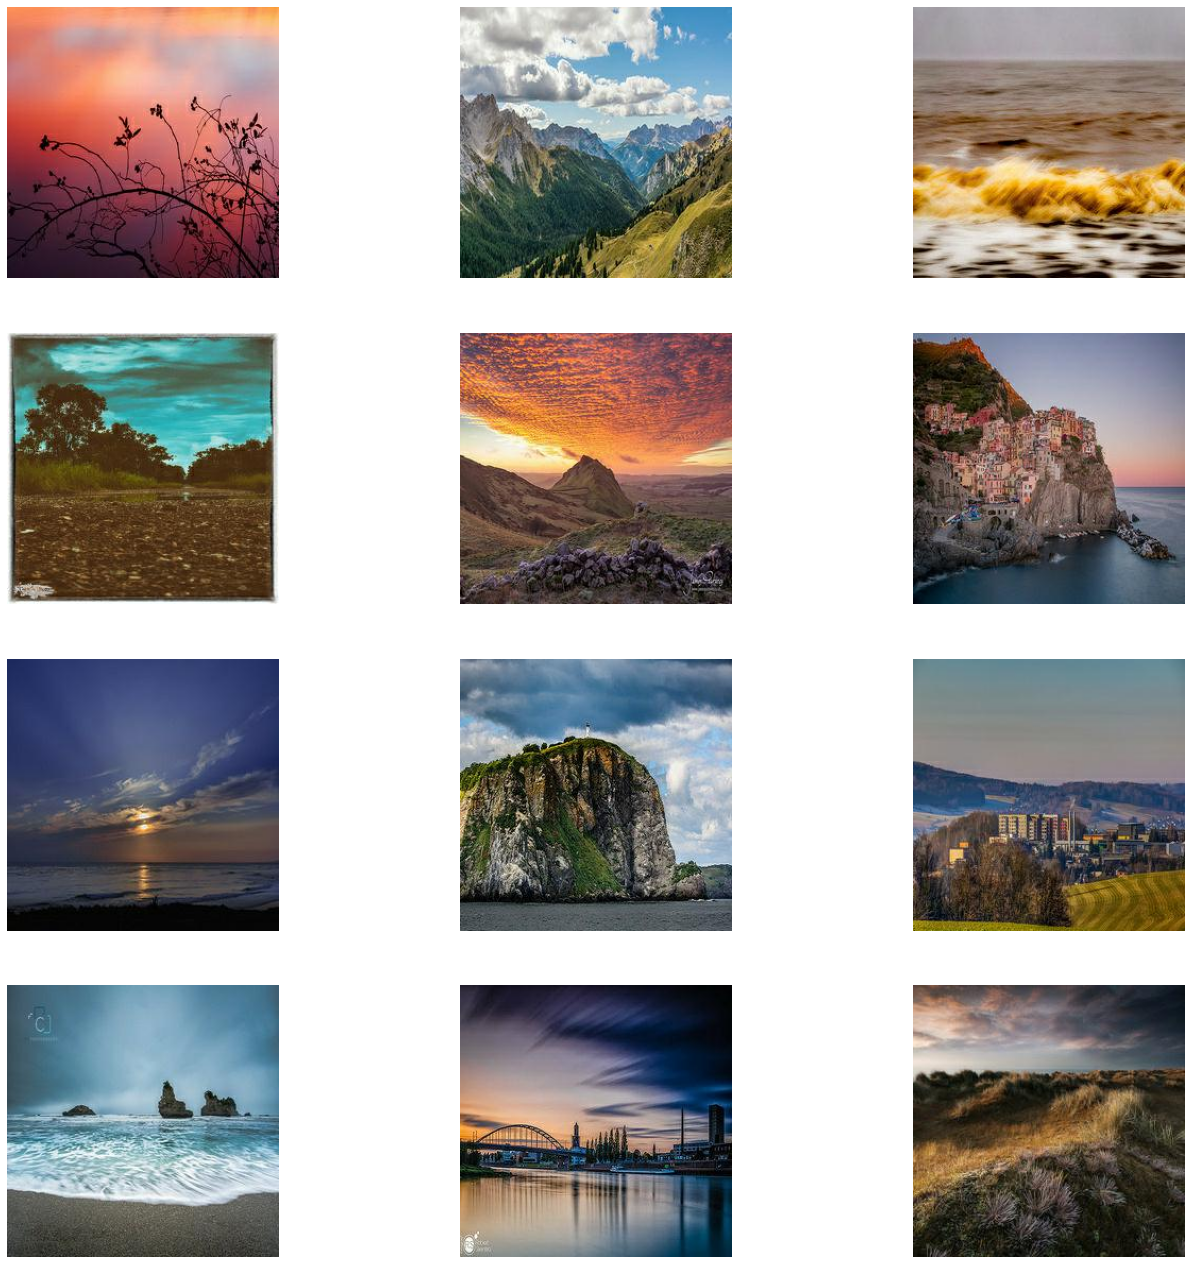

In [15]:
batch_visualization(PHOTO_PATH, 12, is_random=True, figsize=(23, 23))

In [16]:
# Plotting colour histograms for Monet paintings
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    colors = ['red', 'green', 'blue']
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')
    
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

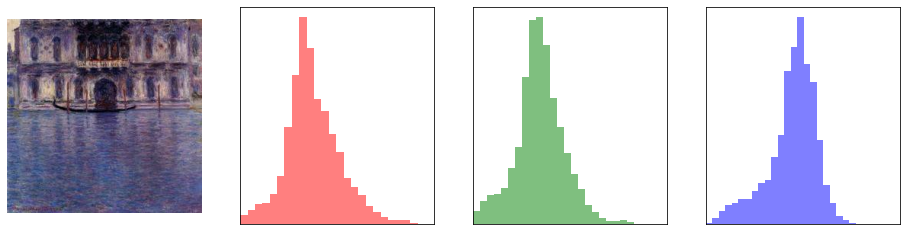

In [17]:
img_path = '../input/gan-getting-started/monet_jpg/05b493ff42.jpg'
color_hist_visualization(img_path)

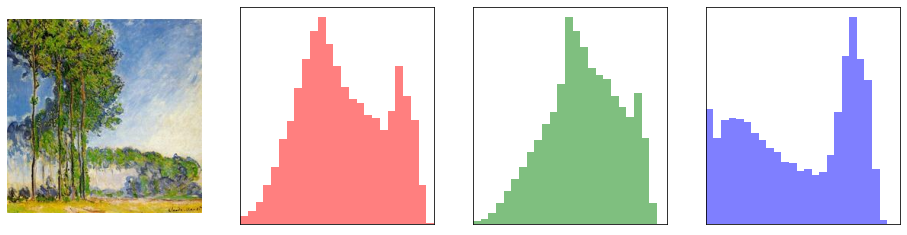

In [18]:
img_path = '../input/gan-getting-started/monet_jpg/052a77c020.jpg'
color_hist_visualization(img_path)

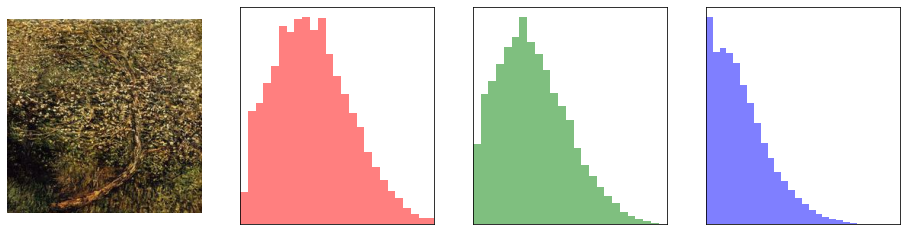

In [19]:
img_path = '../input/gan-getting-started/monet_jpg/09b76b6471.jpg'
color_hist_visualization(img_path)

In [20]:
# Individual channels visualization 
def channels_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')
    
    for i in range(3):
        plt.subplot(1, 4, i + 2)
        tmp_img = np.full_like(img, 0)
        tmp_img[:, :, i] = img[:, :, i]
        plt.imshow(tmp_img)
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    plt.show()

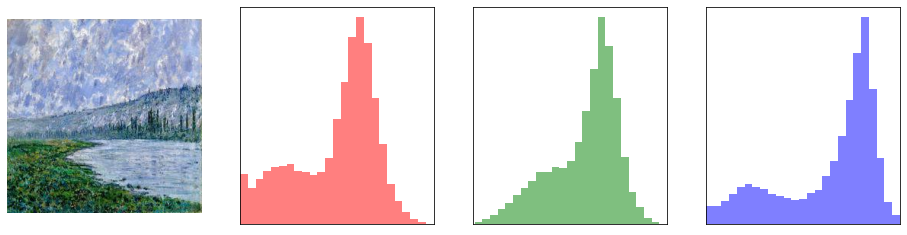

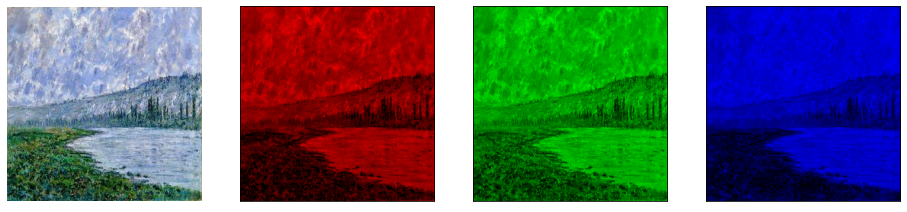

In [21]:
img_path = '../input/gan-getting-started/monet_jpg/0bd913dbc7.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

In [22]:
# Grayscale visualization
def grayscale_visualization(image_path, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    tmp_img = np.full_like(img, 0)
    for i in range(3):
        tmp_img[:, :, i] = img.mean(axis=-1)
    plt.imshow(tmp_img)
    plt.axis('off')
    
    
    plt.show()

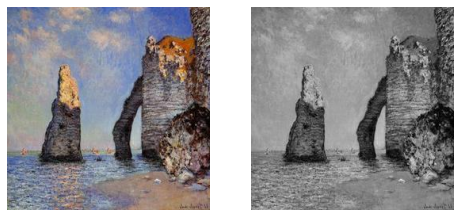

In [23]:
img_path = '../input/gan-getting-started/monet_jpg/990ed28f62.jpg'
grayscale_visualization(img_path)

In [24]:
# monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(10)
# photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(10)

Let's  visualize a photo example and a Monet example.

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [25]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [26]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [27]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

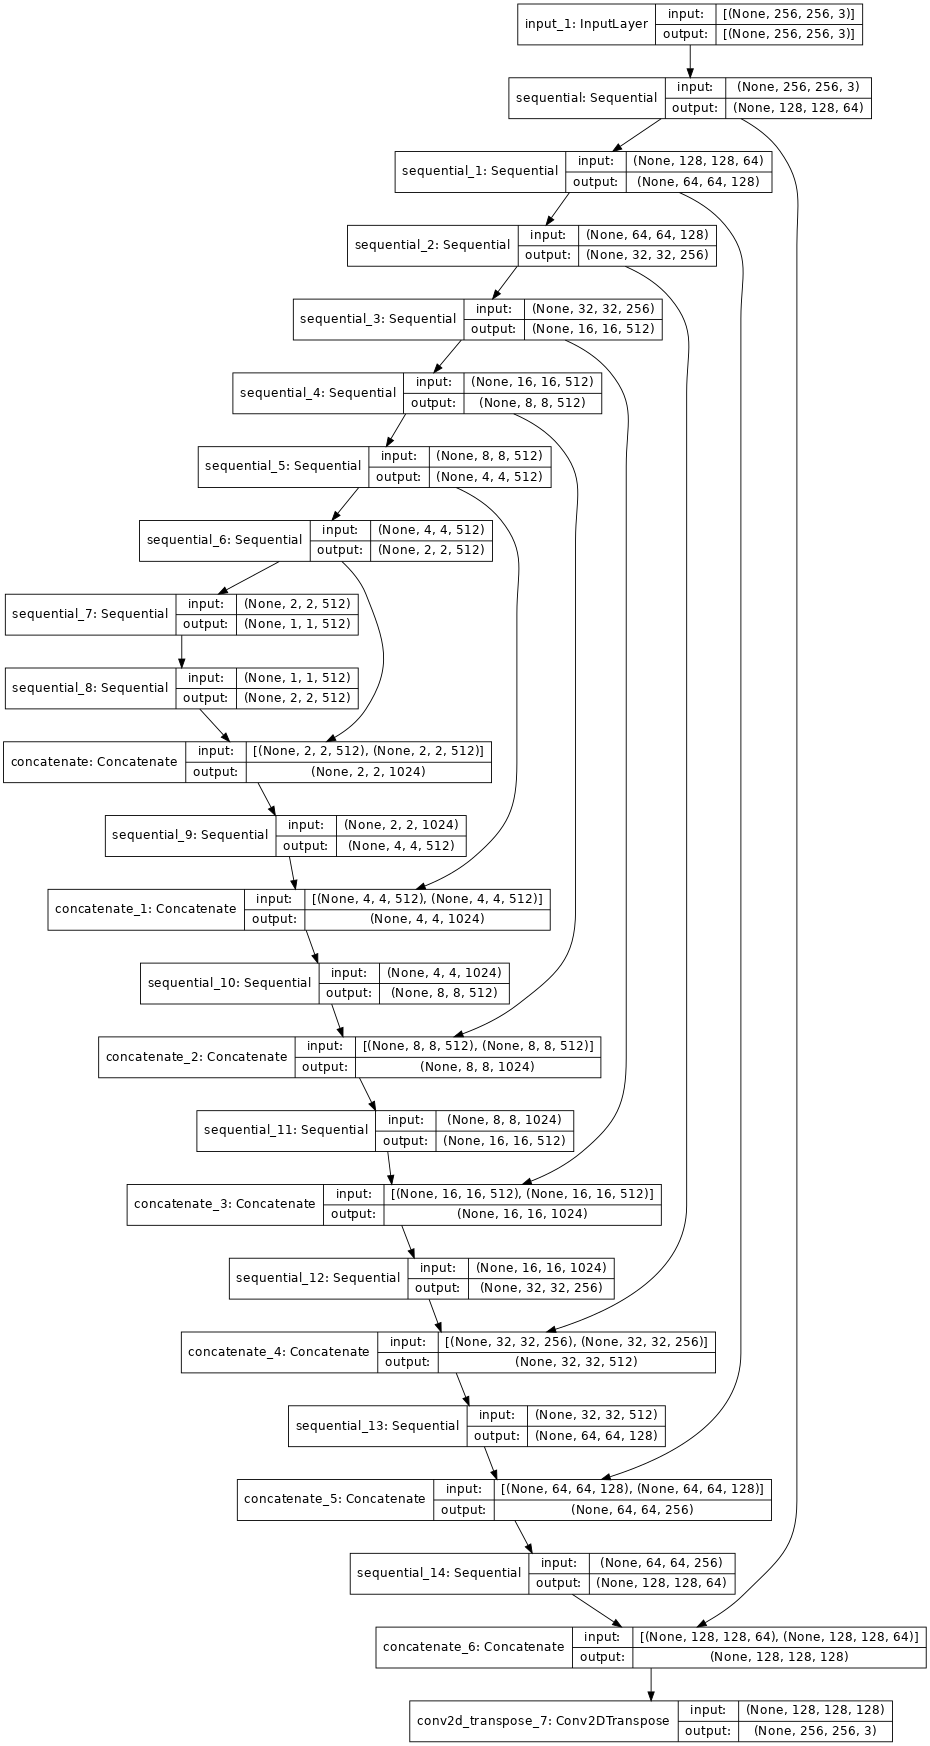

In [28]:
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

In [29]:
example_monet , example_photo = next(iter(full_dataset))

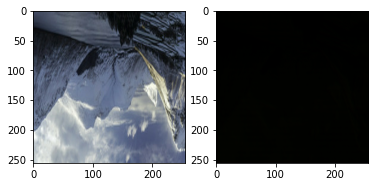

In [30]:
#We pass the denormalized photo so that some result can be seen, since the model is not trained
#photo = example_photo[0,...] (example_photo[2] * 0.5 + 0.5)
photo = (example_photo[0,...] * 0.5 + 0.5)
example_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)

plt.subplot(1,2,1)
plt.imshow(photo, vmin=0, vmax=255) 

plt.subplot(1,2,2)
plt.imshow(example_gen_output_y[0]) 

plt.show()

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [31]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

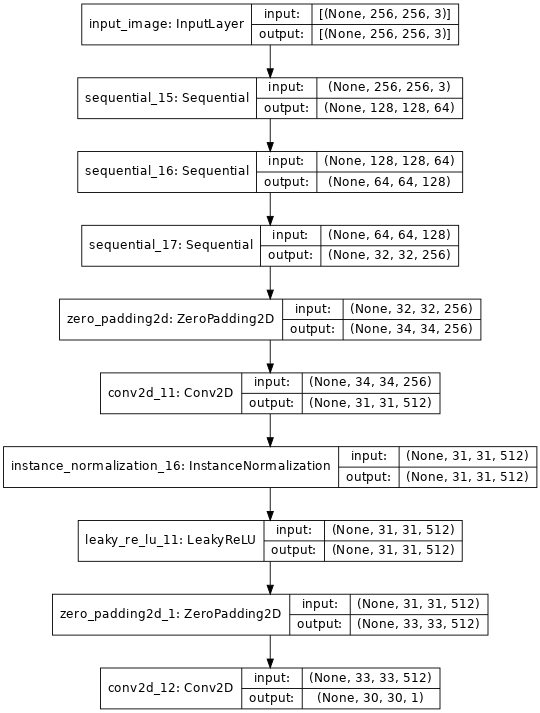

In [32]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

In [33]:
"""
# We pass the denormalized photo so that some result can be seen, since the model is not trained
photo = example_photo[0,...]* 0.5 + 0.5
example_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)
example_disc_out = discriminator_y([example_photo, example_gen_output_y], training=False)

print(example_disc_out.shape)

plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(photo, vmin=0, vmax=255) 

plt.subplot(1,3,2)
plt.imshow(example_gen_output_y[0,...]) 

plt.subplot(1,3,3)
m = example_disc_out[0,...,-1].numpy()*1000
im = plt.imshow(m, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.show()
"""

"\n# We pass the denormalized photo so that some result can be seen, since the model is not trained\nphoto = example_photo[0,...]* 0.5 + 0.5\nexample_gen_output_y = generator_g(photo[tf.newaxis,...], training=False)\nexample_disc_out = discriminator_y([example_photo, example_gen_output_y], training=False)\n\nprint(example_disc_out.shape)\n\nplt.figure(figsize=(10,10))\n\nplt.subplot(1,3,1)\nplt.imshow(photo, vmin=0, vmax=255) \n\nplt.subplot(1,3,2)\nplt.imshow(example_gen_output_y[0,...]) \n\nplt.subplot(1,3,3)\nm = example_disc_out[0,...,-1].numpy()*1000\nim = plt.imshow(m, vmin=-20, vmax=20, cmap='RdBu_r')\nplt.colorbar(im,fraction=0.046, pad=0.04)\n\nplt.show()\n"

In [34]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

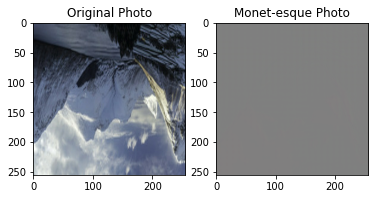

In [35]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

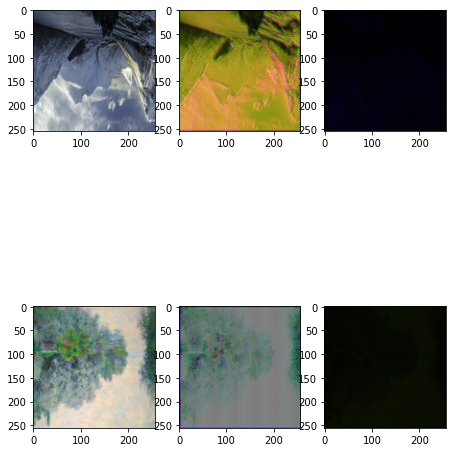

In [36]:
photo = (example_photo[0,...] * 0.5 + 0.5)
monet = (example_monet[0,...] * 0.5 + 0.5)

# From photo we generate Monet (fake) and regenerate the photo (cycle) again
example_gen_output_monet_fake = monet_generator(photo[tf.newaxis,...], training=False)
example_gen_output_photo_cycle =  photo_generator(example_gen_output_monet_fake, training=False)

# We run the discriminator for Monet (fake)
example_disc_out_monet = monet_discriminator(example_gen_output_monet_fake, training=False)


# From Monet we generate photo (fake) and regenerate Monet (cycle) again
example_gen_output_photo_fake =  photo_generator(monet[tf.newaxis,...], training=False)
example_gen_output_monet_cycle = monet_generator(example_gen_output_photo_fake, training=False)

# We execute the discriminator for Photo (fake)
example_disc_out_photo = photo_discriminator(example_gen_output_photo_fake, training=False)


# We present results, as the network is not trained, the outputs are not good, 
# but we modify the scala to be able to have some example images

plt.figure(figsize=(10,10))

# Input Photo
plt.subplot(2,4,1)
plt.imshow(photo, vmin=0, vmax=255) 

# Fake Monet
plt.subplot(2,4,2)
#m = example_gen_output_monet_fake[0,...].numpy()
#print(np.min(m), np.max(m))
contrast = 100 
plt.imshow(example_gen_output_monet_fake[0,...]*contrast) 

# Photo Cycle
plt.subplot(2,4,3)
#m = example_gen_output_photo_cycle[0,...].numpy()
#print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_photo_cycle[0,...]*contrast) 

# Monet discriminator result
#plt.subplot(2,4,4)
#m = example_disc_out_monet[0,...,-1].numpy()
#print(np.min(m), np.max(m))
#contrast = 1000
#im = plt.imshow(m*contrast, vmin=-20, vmax=20, cmap='RdBu_r')
#plt.colorbar(im,fraction=0.046, pad=0.04)



# Input Monet
plt.subplot(2,4,5)
plt.imshow(monet, vmin=0, vmax=255) 

# Fake Photo
plt.subplot(2,4,6)
#m = example_gen_output_photo_fake[0,...].numpy()
#print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_photo_fake[0,...]*contrast) 

# Monet Cycle
plt.subplot(2,4,7)
#m = example_gen_output_monet_cycle[0,...].numpy()
#print(np.min(m), np.max(m))
contrast = 100
plt.imshow(example_gen_output_monet_cycle[0,...]*contrast) 

# Photo discriminator result  
#plt.subplot(2,4,8)
#m = example_disc_out_photo[0,...,-1].numpy()
#print(np.min(m), np.max(m))
#contrast = 1000
#im = plt.imshow(contrast, vmin=-20, vmax=20, cmap='RdBu_r')
#plt.colorbar(im,fraction=0.046, pad=0.04)

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [37]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=15,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [38]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [39]:
# 这个scope起什么作用
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [40]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [41]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [42]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [43]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [44]:
cycle_gan_model.fit(
    #tf.data.Dataset.zip((monet_ds, photo_ds)),
    full_dataset,
    #epochs=25
    epochs=EPOCHS_NUM,
    steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
)

Epoch 1/30
1759/1759 [==============================] - 334s 129ms/step - monet_gen_loss: 4.6360 - photo_gen_loss: 4.8708 - monet_disc_loss: 0.6217 - photo_disc_loss: 0.5606
Epoch 2/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 3.5115 - photo_gen_loss: 3.6435 - monet_disc_loss: 0.5958 - photo_disc_loss: 0.5759
Epoch 3/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 3.3182 - photo_gen_loss: 3.4139 - monet_disc_loss: 0.6024 - photo_disc_loss: 0.5868
Epoch 4/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 3.1132 - photo_gen_loss: 3.2549 - monet_disc_loss: 0.6159 - photo_disc_loss: 0.5829
Epoch 5/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 3.0429 - photo_gen_loss: 3.2286 - monet_disc_loss: 0.6182 - photo_disc_loss: 0.5823
Epoch 6/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 2.9852 - photo_gen_loss: 3.2176 - monet_

# Visualize our Monet-esque photos

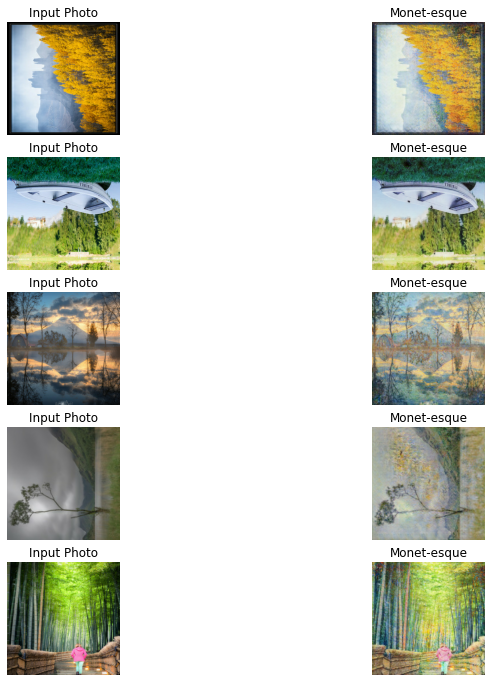

In [45]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [46]:
import PIL
#! mkdir ../images

In [47]:
"""
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
"""

'\ni = 1\nfor img in photo_ds:\n    prediction = monet_generator(img, training=False)[0].numpy()\n    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)\n    im = PIL.Image.fromarray(prediction)\n    im.save("../images/" + str(i) + ".jpg")\n    i += 1\n'

In [48]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [49]:
import os
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [50]:
import shutil
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038


# Conclusion 

In conclusion, this competition has invited you to embark on a fascinating exploration at the intersection of data science and artistic ingenuity. Through the lens of Generative Adversarial Networks (GANs), you've delved into the realm of recreating the iconic style of Claude Monet, leveraging algorithms to breathe life into digital canvases. Throughout this journey, you've grappled with the intricate dance between the generator and the discriminator, striving to create Monet-esque masterpieces that could seamlessly blend into the realm of true art. This challenge has not only tested your technical prowess but also your ability to infuse creativity into the world of algorithms.

As you submit your collection of 7,000 to 10,000 Monet-style images, remember that each pixel bears witness to the fusion of data science and artistic expression. Regardless of the outcome, this endeavor has pushed the boundaries of what can be achieved in the realm of digital artistry. Your participation has added a brushstroke to the canvas of technological creativity, bridging the gap between the analytical and the aesthetic. Congratulations on your journey through this captivating competition, where science met art in a symphony of algorithms and imagination. Your contributions have truly been a brushstroke in the evolving masterpiece of the digital landscape. Until the next creative challenge, continue pushing the boundaries and exploring the infinite possibilities that lie at the crossroads of technology and artistic expression. Well done!